### Using moving average model for stock prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('widget_sales.csv')
df

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108
...,...
495,64.087371
496,63.992081
497,63.029894
498,61.671797


* plotting the series

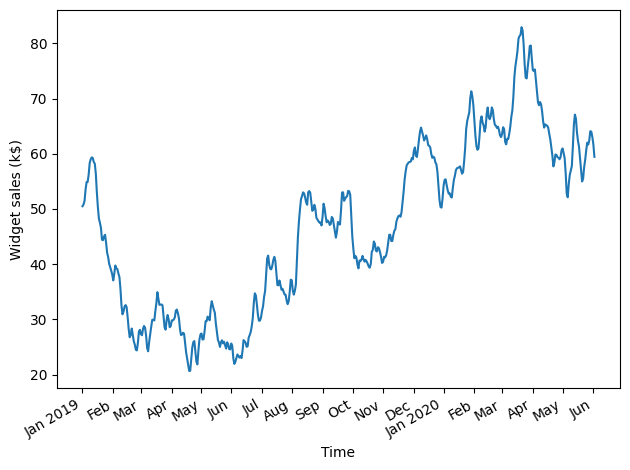

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

* performing adfuller, kpss and plotting acf

In [4]:
from statsmodels.tsa.stattools import adfuller
Adf_result = adfuller(df['widget_sales'])

print(f'ADF statistic: {Adf_result[0]}')
print(f'P value: {Adf_result[1]}')
print(f'Critical values : {Adf_result[4]}')

ADF statistic: -1.5121662069359048
P value: 0.5274845352272605
Critical values : {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}



As p-value is greater than 0.05 and adf-statistic is greater than all the critical values, we can conclude that the series is non-stationary and transformation needs to be applied 


* applying diff transformation

In [5]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

In [6]:
Adf_result = adfuller(widget_sales_diff)

print(f'ADF statistic: {Adf_result[0]}')
print(f'P value: {Adf_result[1]}')
print(f'Critical values : {Adf_result[4]}')

ADF statistic: -10.576657780341959
P value: 7.076922818587193e-19
Critical values : {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}


For the difference series, adf statistic is less than all of the critical values and p-value is less than 0.05 so we can conclude that the series is stationary

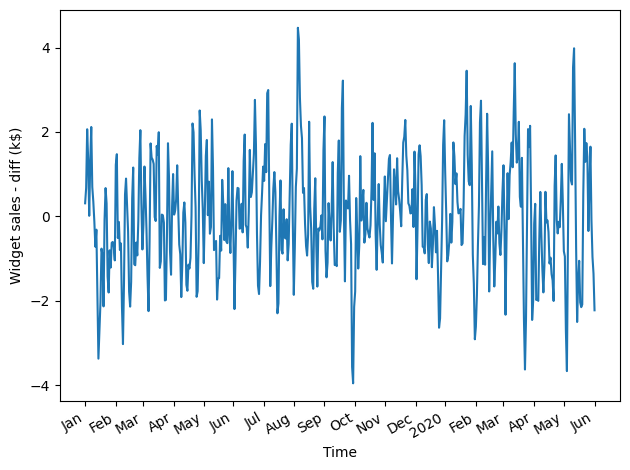

In [7]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

Additional take on checking for stationarity

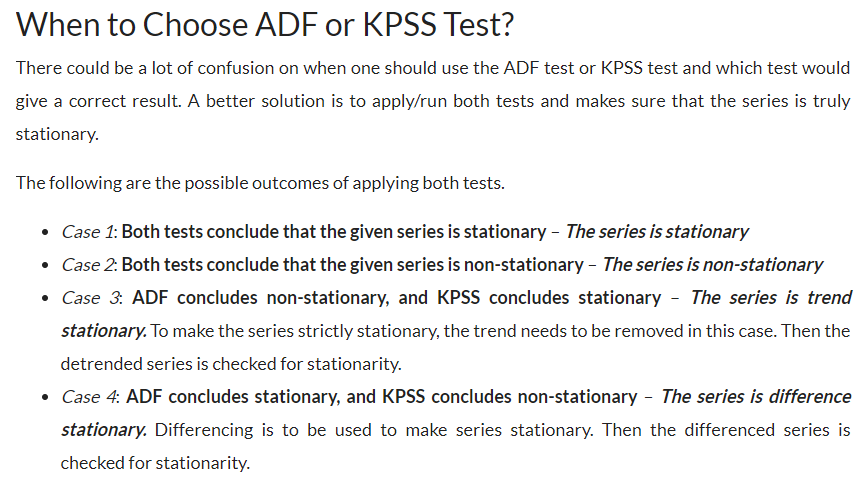

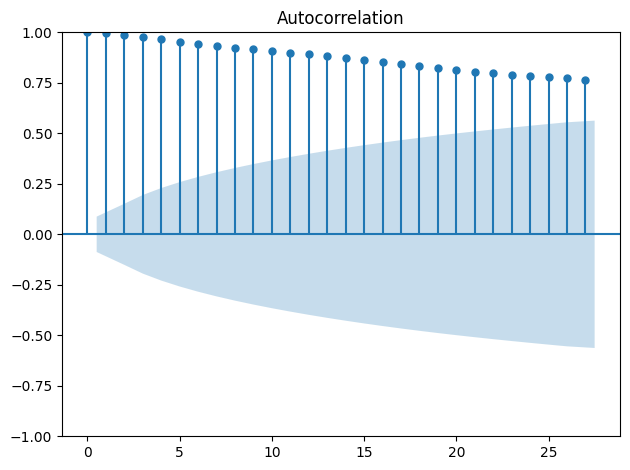

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['widget_sales'])
plt.tight_layout()

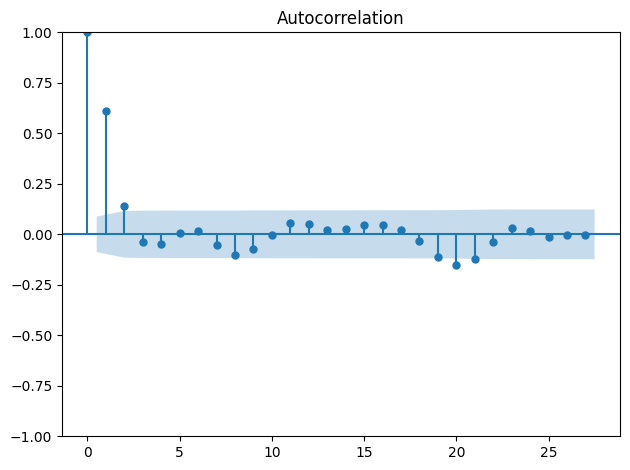

In [23]:
plot_acf(widget_sales_diff)
plt.tight_layout()

Since after lag of 2, the autocorrelation coefficients become abruptly non-significant, moving-average seems to be a process of order 2

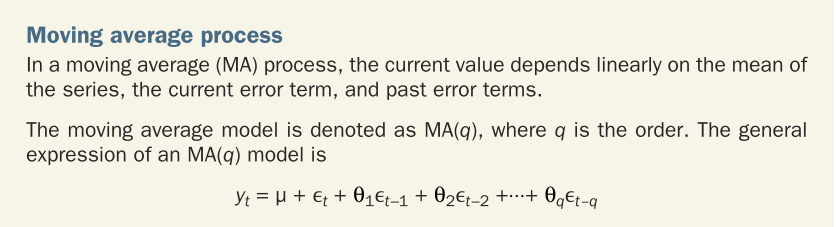

* moving average process flowchart

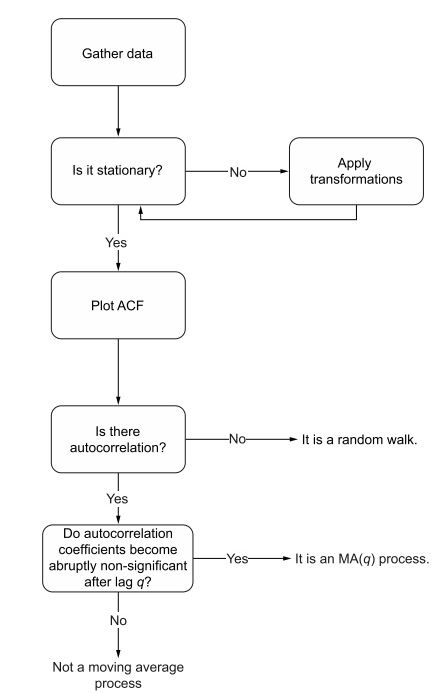

In [10]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
train = df_diff[:int(0.9*len(df_diff))] 
test = df_diff[int(0.9*len(df_diff)):]

In [11]:
len(train), len(test)

(449, 50)

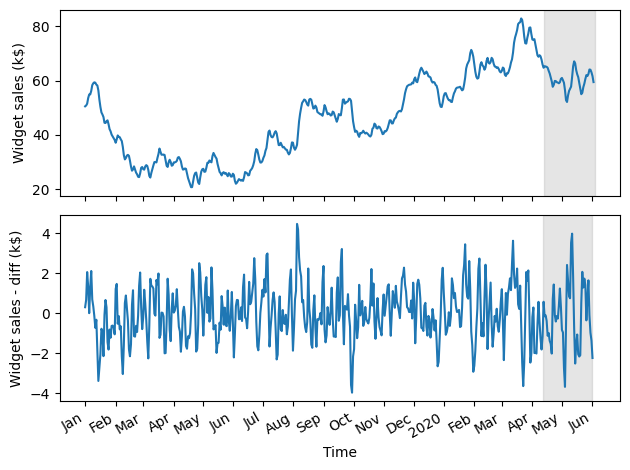

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time') 
ax1.set_ylabel('Widget sales (k$)') 
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff']) 
ax2.set_xlabel('Time') 
ax2.set_ylabel('Widget sales - diff (k$)') 
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate() 
plt.tight_layout()

To avoid simply predicting the mean beyond two timesteps into the future, we
need to develop a function that will predict two timesteps or less at a time, until 50 predictions are made, so that we can compare our predictions against the observed values of the test set. This method is called rolling forecasts. On the first pass, we will train on the first 449 timesteps and predict timesteps 450 and 451. Then, on the second pass, we will train on the first 451 timesteps, and predict timesteps 452 and 453. This is repeated until we finally predict the values at timesteps 498 and 499.

We will compare our fitted MA(2) model to two baselines: the historical mean and the last value. That way, we can make sure that an MA(2) model will yield better predictions than naive forecasts, which should be the case, since we know the stationary process is an MA(2) process.

**Rolling forecast function**
* Next, we define our rolling_forecast function. It will take in a DataFrame, the length of the training set, the forecast horizon, a window size, and a method. The DataFrame contains the entire time series.
* The train_len parameter initializes the number of data points that can be used to fit a model. As predictions are done, we can update this to simulate the observation of new values and then use them to make the next sequence of forecasts.
* The horizon parameter is equal to the length of the test set and represents how many values must be predicted.
* The window parameter specifies how many timesteps are predicted at a time. In our case, because we have an MA(2) process, the window will be equal to 2.
* The method parameter specifies what model to use. The same function allows us to generate forecasts from the naive methods and the MA(2) model.

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str)->list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2)) 
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

Generate predictions

In [20]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA') 

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


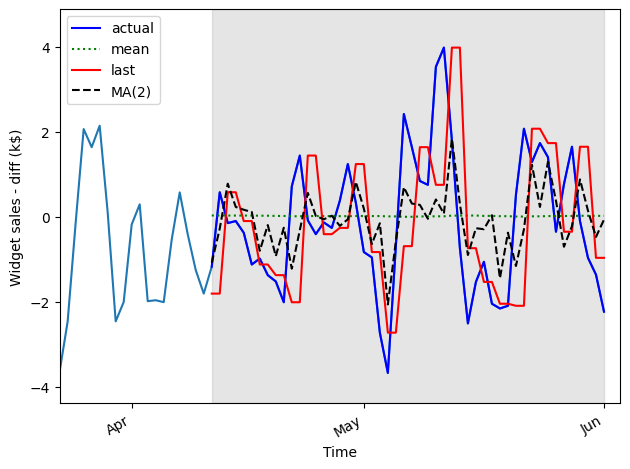

In [21]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714498162603


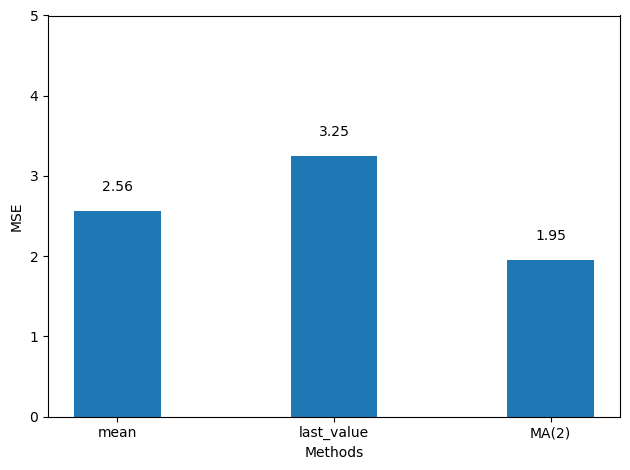

In [27]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

As we can see, the moving average model generates minimal MSE

Now that we have our champion model on the stationary series, we need to inverse-transform our predictions to bring them back to the original scale of the untransformed dataset. 

To reverse first order difference:
$$
y1 = y0 + y'1 = y0 + y1 – y0 = y1
$$
To reverse second order difference: 
$$
y2 = y0 + y'1 + y'2 = y0 + y1 – y0 + y2 – y1 = (y0 – y0) + (y1 – y1) + y2 = y2
$$

In [35]:
df['pred_widget_sales'] = pd.Series(dtype=float)
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

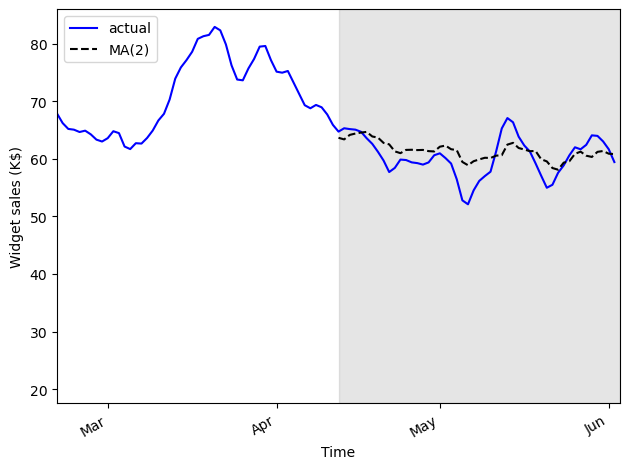

In [39]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
r2_MA_undiff = r2_score(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
mape_MA_undiff = mean_absolute_percentage_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(f"MAE: {mae_MA_undiff}")
print(f"r2 score: {r2_MA_undiff}")
print(f"MAPE: {mape_MA_undiff}")

MAE: 2.3244709245259547
r2 score: 0.32644160360798935
MAPE: 0.03940801286485694
